# **Imports**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as numpy
from PIL import Image
import numpy as np

In [3]:
from nltk.translate.bleu_score import corpus_bleu

In [4]:
from tensorflow.keras.utils import to_categorical, plot_model

2024-07-17 16:19:29.759366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 16:19:29.759467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 16:19:29.899104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
import os

In [9]:
import tensorflow as tf

In [10]:
from keras.applications.xception import Xception
from keras.models import Model

In [11]:
import string
from textblob import TextBlob
import spacy
from collections import Counter
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import re

In [12]:
from collections import defaultdict
from keras.preprocessing import image
from keras.applications.xception import preprocess_input

# **Dataset Loading**

In [113]:
image_dir = "/kaggle/input/flickr8k/Images"
captions_dir = "/kaggle/input/flickr8k/captions.txt"

In [114]:
captions_dict = defaultdict(list)

In [115]:
with open(captions_dir, 'r') as file:
    for line in file:
        line = line.strip()
        if not line:
            continue
        image_file, caption = line.split(',', 1)
        captions_dict[image_file].append(caption)

In [116]:
image_paths = []
captions = []

In [117]:
for image_file, captions_list in captions_dict.items():
    if len(captions_list) < 5:
        captions_list += [''] * (5 - len(captions_list))
    image_paths.append(f'/kaggle/input/flickr8k/Images/{image_file}')
    captions.append(captions_list[:5])

In [118]:
data = {
    'image_path': image_paths,
    'caption_1': [cap[0] for cap in captions],
    'caption_2': [cap[1] for cap in captions],
    'caption_3': [cap[2] for cap in captions],
    'caption_4': [cap[3] for cap in captions],
    'caption_5': [cap[4] for cap in captions],
}

In [120]:
df = pd.DataFrame(data)
df = df.drop(index=0)
df.head()

,image_path,caption_1,caption_2,caption_3,caption_4,caption_5
1,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
2,/kaggle/input/flickr8k/Images/1001773457_577c3...,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
3,/kaggle/input/flickr8k/Images/1002674143_1b742...,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
4,/kaggle/input/flickr8k/Images/1003163366_44323...,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
5,/kaggle/input/flickr8k/Images/1007129816_e7944...,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...


In [121]:
print(len(df))

8091


> **Just to confirm that there is no null value**

In [122]:
df.isnull().sum()

image_path    0
caption_1     0
caption_2     0
caption_3     0
caption_4     0
caption_5     0
dtype: int64

In [123]:
df.to_csv('Flickr8K3.csv', index=False)
print("DataFrame saved as 'Flickr8K3.csv'")

DataFrame saved as 'Flickr8K3.csv'


In [19]:
df = pd.read_csv("/kaggle/input/flickr8k3/Flickr8K3 (1).csv")
df.head()

,image_path,caption_1,caption_2,caption_3,caption_4,caption_5
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
1,/kaggle/input/flickr8k/Images/1001773457_577c3...,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
2,/kaggle/input/flickr8k/Images/1002674143_1b742...,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
3,/kaggle/input/flickr8k/Images/1003163366_44323...,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
4,/kaggle/input/flickr8k/Images/1007129816_e7944...,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...


# **Text Preprocessing**

In [20]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

In [21]:
exclude = string.punctuation
print(exclude)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [22]:
def removePunc(text):
    return text.translate(str.maketrans('','',exclude))

In [23]:
def remove_whitespace(column):
    return column.str.strip

In [29]:
def startend(text):
    text = 'startseq ' + " ".join([word for word in text.split() if len(word)>1]) + ' endseq'
    return text

In [24]:
df['caption_1'] = df['caption_1'].str.lower()
df['caption_2'] = df['caption_2'].str.lower()
df['caption_3'] = df['caption_3'].str.lower()
df['caption_4'] = df['caption_4'].str.lower()
df['caption_5'] = df['caption_5'].str.lower()

In [25]:
df['caption_1'] = df['caption_1'].apply(remove_html_tags)
df['caption_2'] = df['caption_2'].apply(remove_html_tags)
df['caption_3'] = df['caption_3'].apply(remove_html_tags)
df['caption_4'] = df['caption_4'].apply(remove_html_tags)
df['caption_5'] = df['caption_5'].apply(remove_html_tags)

In [26]:
df['caption_1'] = df['caption_1'].apply(removePunc)
df['caption_2'] = df['caption_2'].apply(removePunc)
df['caption_3'] = df['caption_3'].apply(removePunc)
df['caption_4'] = df['caption_4'].apply(removePunc)
df['caption_5'] = df['caption_5'].apply(removePunc)

In [27]:
df['caption_1'] = df['caption_1'].str.strip()
df['caption_2'] = df['caption_2'].str.strip()
df['caption_3'] = df['caption_3'].str.strip()
df['caption_4'] = df['caption_4'].str.strip()
df['caption_5'] = df['caption_5'].str.strip()

In [30]:
df['caption_1_final'] = df['caption_1'].apply(startend)
df['caption_2_final'] = df['caption_2'].apply(startend)
df['caption_3_final'] = df['caption_3'].apply(startend)
df['caption_4_final'] = df['caption_4'].apply(startend)
df['caption_5_final'] = df['caption_5'].apply(startend)

In [31]:
df.head()

,image_path,caption_1,caption_2,caption_3,caption_4,caption_5,caption_1_final,caption_2_final,caption_3_final,caption_4_final,caption_5_final
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,a child in a pink dress is climbing up a set o...,a girl going into a wooden building,a little girl climbing into a wooden playhouse,a little girl climbing the stairs to her playh...,a little girl in a pink dress going into a woo...,startseq child in pink dress is climbing up se...,startseq girl going into wooden building endseq,startseq little girl climbing into wooden play...,startseq little girl climbing the stairs to he...,startseq little girl in pink dress going into ...
1,/kaggle/input/flickr8k/Images/1001773457_577c3...,a black dog and a spotted dog are fighting,a black dog and a tricolored dog playing with ...,a black dog and a white dog with brown spots a...,two dogs of different breeds looking at each o...,two dogs on pavement moving toward each other,startseq black dog and spotted dog are fightin...,startseq black dog and tricolored dog playing ...,startseq black dog and white dog with brown sp...,startseq two dogs of different breeds looking ...,startseq two dogs on pavement moving toward ea...
2,/kaggle/input/flickr8k/Images/1002674143_1b742...,a little girl covered in paint sits in front o...,a little girl is sitting in front of a large p...,a small girl in the grass plays with fingerpai...,there is a girl with pigtails sitting in front...,young girl with pigtails painting outside in t...,startseq little girl covered in paint sits in ...,startseq little girl is sitting in front of la...,startseq small girl in the grass plays with fi...,startseq there is girl with pigtails sitting i...,startseq young girl with pigtails painting out...
3,/kaggle/input/flickr8k/Images/1003163366_44323...,a man lays on a bench while his dog sits by him,a man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,a shirtless man lies on a park bench with his dog,man laying on bench holding leash of dog sitti...,startseq man lays on bench while his dog sits ...,startseq man lays on the bench to which white ...,startseq man sleeping on bench outside with wh...,startseq shirtless man lies on park bench with...,startseq man laying on bench holding leash of ...
4,/kaggle/input/flickr8k/Images/1007129816_e7944...,a man in an orange hat starring at something,a man wears an orange hat and glasses,a man with gauges and glasses is wearing a bli...,a man with glasses is wearing a beer can croch...,the man with pierced ears is wearing glasses a...,startseq man in an orange hat starring at some...,startseq man wears an orange hat and glasses e...,startseq man with gauges and glasses is wearin...,startseq man with glasses is wearing beer can ...,startseq the man with pierced ears is wearing ...


In [32]:
df.to_csv('finaleflickr.csv', index=False)

# **Extracting feature vectors from images**

In [51]:
base_model = Xception(weights='imagenet', include_top=False, pooling='avg')

In [52]:
model = Model(inputs=base_model.input, outputs=base_model.output)

In [53]:
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add_12[0][0]    

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

None


In [54]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_array = preprocess_input(img_array)
    return img_array

In [55]:
def extract_features(img_path, model):
    img_array = load_and_preprocess_image(img_path)
    features = model.predict(img_array, verbose = 0)
    return features

In [56]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [57]:
features = []

In [ ]:
for i in range(0,(len(df))):
    img_path = df.iloc[i]['image_path']
    feature = extract_features(img_path, model)
    features.append(feature)
print(features)

In [ ]:
print(features)

In [60]:
features_array = np.array(features)
np.save('features5.npy', features_array)

# **Tokenising the vocabulary**

In [35]:
df = pd.read_csv("/kaggle/input/finaleflickr/finaleflickr.csv")

In [36]:
df.head()

,image_path,caption_1,caption_2,caption_3,caption_4,caption_5,caption_1_final,caption_2_final,caption_3_final,caption_4_final,caption_5_final
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,a child in a pink dress is climbing up a set o...,a girl going into a wooden building,a little girl climbing into a wooden playhouse,a little girl climbing the stairs to her playh...,a little girl in a pink dress going into a woo...,startseq child in pink dress is climbing up se...,startseq girl going into wooden building endseq,startseq little girl climbing into wooden play...,startseq little girl climbing the stairs to he...,startseq little girl in pink dress going into ...
1,/kaggle/input/flickr8k/Images/1001773457_577c3...,a black dog and a spotted dog are fighting,a black dog and a tricolored dog playing with ...,a black dog and a white dog with brown spots a...,two dogs of different breeds looking at each o...,two dogs on pavement moving toward each other,startseq black dog and spotted dog are fightin...,startseq black dog and tricolored dog playing ...,startseq black dog and white dog with brown sp...,startseq two dogs of different breeds looking ...,startseq two dogs on pavement moving toward ea...
2,/kaggle/input/flickr8k/Images/1002674143_1b742...,a little girl covered in paint sits in front o...,a little girl is sitting in front of a large p...,a small girl in the grass plays with fingerpai...,there is a girl with pigtails sitting in front...,young girl with pigtails painting outside in t...,startseq little girl covered in paint sits in ...,startseq little girl is sitting in front of la...,startseq small girl in the grass plays with fi...,startseq there is girl with pigtails sitting i...,startseq young girl with pigtails painting out...
3,/kaggle/input/flickr8k/Images/1003163366_44323...,a man lays on a bench while his dog sits by him,a man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,a shirtless man lies on a park bench with his dog,man laying on bench holding leash of dog sitti...,startseq man lays on bench while his dog sits ...,startseq man lays on the bench to which white ...,startseq man sleeping on bench outside with wh...,startseq shirtless man lies on park bench with...,startseq man laying on bench holding leash of ...
4,/kaggle/input/flickr8k/Images/1007129816_e7944...,a man in an orange hat starring at something,a man wears an orange hat and glasses,a man with gauges and glasses is wearing a bli...,a man with glasses is wearing a beer can croch...,the man with pierced ears is wearing glasses a...,startseq man in an orange hat starring at some...,startseq man wears an orange hat and glasses e...,startseq man with gauges and glasses is wearin...,startseq man with glasses is wearing beer can ...,startseq the man with pierced ears is wearing ...


In [37]:
all_captions = []
for i in range(len(df)):
    for j in range(6,11):
        all_captions.append(df.iloc[i][j])

/tmp/ipykernel_35/3383831275.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_captions.append(df.iloc[i][j])


In [38]:
print(len(all_captions))

40455


In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [40]:
max_length = max(len(caption.split()) for caption in all_captions)

In [41]:
print(f"Vocab Size:{vocab_size}, Max Length:{max_length}")

Vocab Size:8811, Max Length:34


In [42]:
captions_array = np.array(all_captions)
np.save('all_captions.npy', captions_array)

# **Data Generator**

In [62]:
def ImageGenerator(df, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for k in range(len(df)):
            n += 1
            captions = []
            captions.append(df.iloc[k]['caption_1_final'])
            captions.append(df.iloc[k]['caption_2_final'])
            captions.append(df.iloc[k]['caption_3_final'])
            captions.append(df.iloc[k]['caption_4_final'])
            captions.append(df.iloc[k]['caption_5_final'])
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(features[i].flatten())
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield ((X1, X2), y)
                X1, X2, y = list(), list(), list()
                n = 0

In [49]:
def check_multiple_samples(generator, num_batches=1, num_samples=5):
    for _ in range(num_batches):
        (X1, X2), y = next(generator)
        print("X1 (image features) shape:", X1.shape)
        print("X2 (input sequences) shape:", X2.shape)
        print("y (output sequences) shape:", y.shape)
        
        for i in range(num_samples):
            print(f"\nSample {i+1}:")
            print("X1 (image features):", X1[i])
            print("X2 (input sequences):", X2[i])
            print("y (output sequences):", y[i])
            print("Indices of 1 in y sample:", np.where(y[i] == 1))
        
        break

# Example usage
# Assuming df, features, tokenizer, max_length, vocab_size, and batch_size are already defined
generator = ImageGenerator(df, features, tokenizer, max_length, vocab_size, batch_size=32)
check_multiple_samples(generator, num_batches=1, num_samples=5)

X1 (image features) shape: (1746, 2048)
X2 (input sequences) shape: (1746, 34)
y (output sequences) shape: (1746, 8811)

Sample 1:
X1 (image features): [0.         0.21514879 0.00040347 ... 0.20985599 0.39448452 0.0368708 ]
X2 (input sequences): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
y (output sequences): [0. 0. 0. ... 0. 0. 0.]
Indices of 1 in y sample: (array([41]),)

Sample 2:
X1 (image features): [0.         0.06793422 0.02688254 ... 0.         0.04563471 0.05668405]
X2 (input sequences): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1 41]
y (output sequences): [0. 0. 0. ... 0. 0. 0.]
Indices of 1 in y sample: (array([3]),)

Sample 3:
X1 (image features): [0.21430275 0.00188807 0.24349634 ... 0.2090363  0.15304066 0.10110763]
X2 (input sequences): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1 41  3]
y (output sequences): [0. 0. 0. ... 0. 0. 0.]
Ind

# **CNN-LSTM model**

In [63]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(512, use_cudnn=False)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [64]:
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

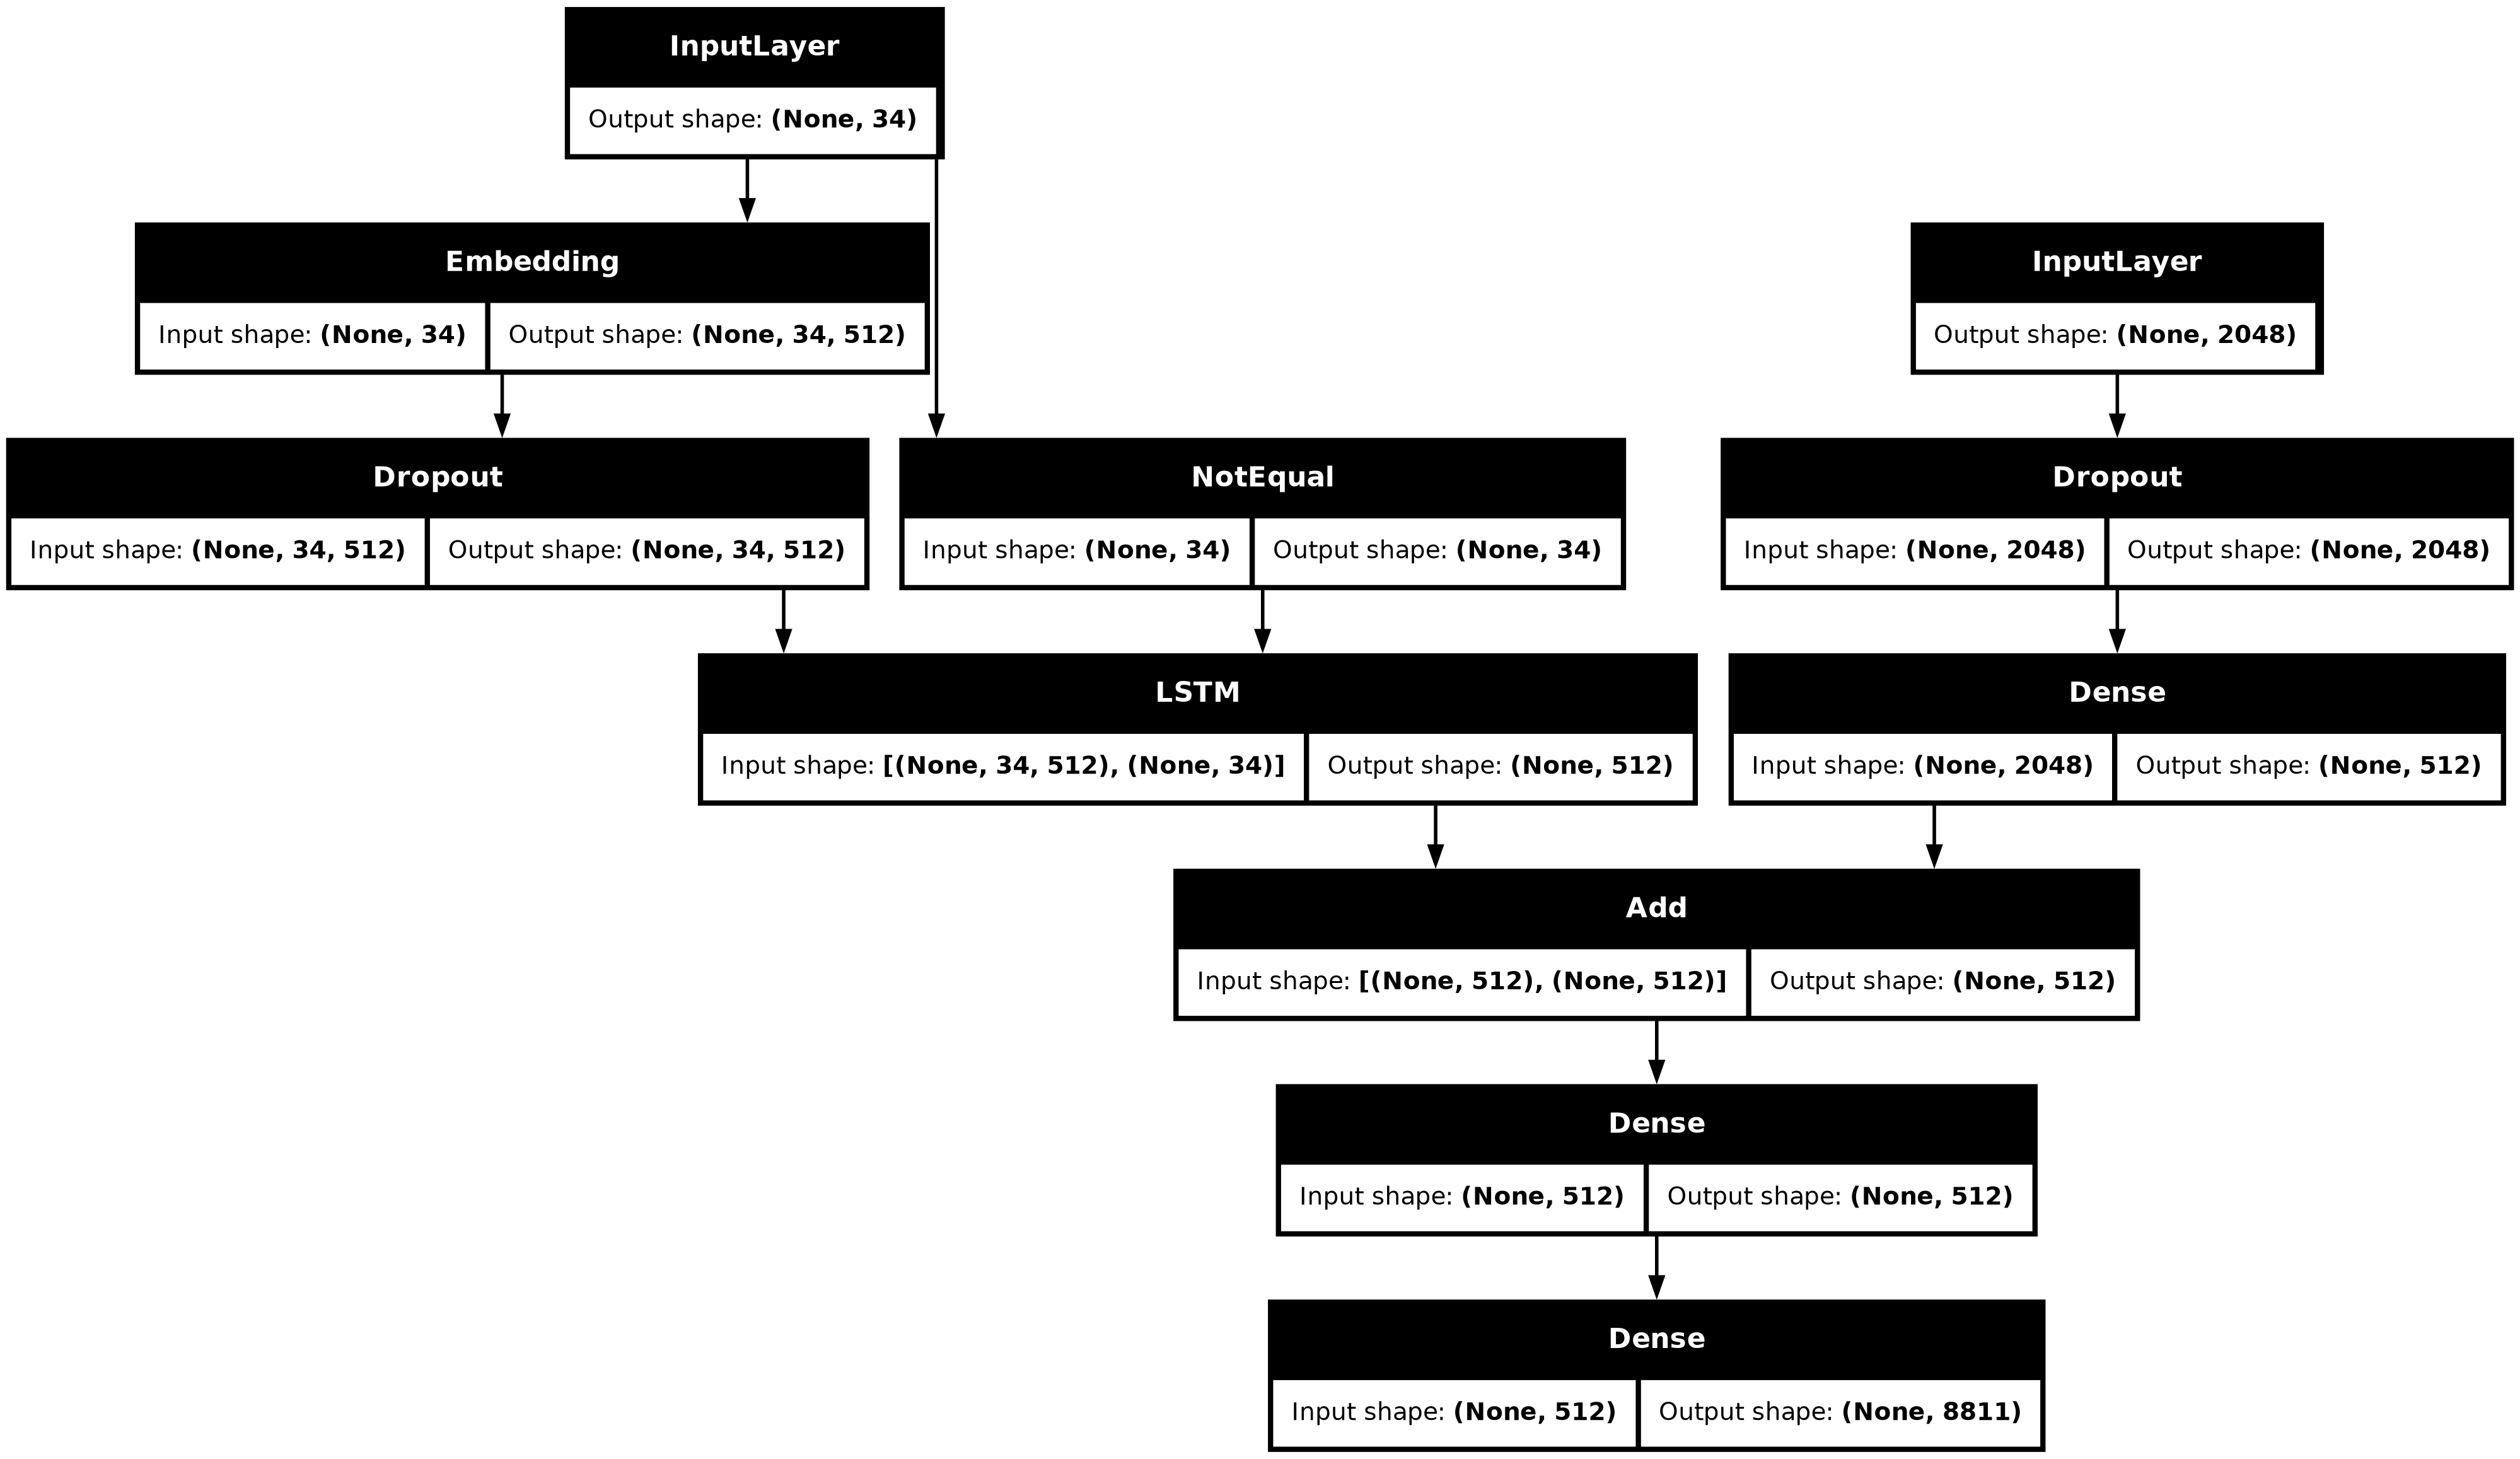

In [65]:
plot_model(model, show_shapes=True)

In [32]:
features_array = np.load('/kaggle/input/finalfeatures/features3.npy')

In [ ]:
print(features)

In [66]:
print(features_array[4].flatten().shape)

(2048,)


In [67]:
epochs = 20
batch_size = 32
steps = len(df) // batch_size

for i in range(epochs):
    generator = ImageGenerator(df, features_array, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

W0000 00:00:1721235833.135836     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235833.139033     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235833.289533     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/252 ━━━━━━━━━━━━━━━━━━━━ 31:33 8s/step - loss: 9.0892

W0000 00:00:1721235833.431489     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235838.051496     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235838.192637     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/252 ━━━━━━━━━━━━━━━━━━━━ 20:34 5s/step - loss: 9.0510

W0000 00:00:1721235838.371650     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235843.071190     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235843.201068     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/252 ━━━━━━━━━━━━━━━━━━━━ 20:38 5s/step - loss: 8.9972

W0000 00:00:1721235843.376808     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235848.028078     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235848.170338     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/252 ━━━━━━━━━━━━━━━━━━━━ 20:29 5s/step - loss: 8.9179

W0000 00:00:1721235848.305353     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235853.063595     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235853.206911     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/252 ━━━━━━━━━━━━━━━━━━━━ 20:29 5s/step - loss: 8.8141

W0000 00:00:1721235853.342892     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235857.961249     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235858.093639     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  6/252 ━━━━━━━━━━━━━━━━━━━━ 20:21 5s/step - loss: 8.6866

W0000 00:00:1721235858.267351     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235863.058395     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235863.211024     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/252 ━━━━━━━━━━━━━━━━━━━━ 20:22 5s/step - loss: 8.5611

W0000 00:00:1721235863.364501     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235868.108370     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235868.252022     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/252 ━━━━━━━━━━━━━━━━━━━━ 20:18 5s/step - loss: 8.4445

W0000 00:00:1721235868.396860     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235873.177229     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235873.319040     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/252 ━━━━━━━━━━━━━━━━━━━━ 20:15 5s/step - loss: 8.3412

W0000 00:00:1721235873.461765     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235878.120506     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235878.273634     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/252 ━━━━━━━━━━━━━━━━━━━━ 20:09 5s/step - loss: 8.2481

W0000 00:00:1721235878.430914     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235883.181345     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235883.322051     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/252 ━━━━━━━━━━━━━━━━━━━━ 20:05 5s/step - loss: 8.1614

W0000 00:00:1721235883.464341     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235888.291675     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235888.432153     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/252 ━━━━━━━━━━━━━━━━━━━━ 20:03 5s/step - loss: 8.0809

W0000 00:00:1721235888.611046     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 13/252 ━━━━━━━━━━━━━━━━━━━━ 18:24 5s/step - loss: 8.0062

W0000 00:00:1721235893.665640     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235893.809449     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/252 ━━━━━━━━━━━━━━━━━━━━ 18:27 5s/step - loss: 7.9371

W0000 00:00:1721235893.946568     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235898.696537     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235898.828424     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/252 ━━━━━━━━━━━━━━━━━━━━ 18:29 5s/step - loss: 7.8731

W0000 00:00:1721235898.959511     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/252 ━━━━━━━━━━━━━━━━━━━━ 17:15 4s/step - loss: 7.8143

W0000 00:00:1721235904.023104     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235904.164670     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/252 ━━━━━━━━━━━━━━━━━━━━ 17:21 4s/step - loss: 7.7597

W0000 00:00:1721235904.326929     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235909.168513     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235909.171968     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235909.304205     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/252 ━━━━━━━━━━━━━━━━━━━━ 17:26 4s/step - loss: 7.7081

W0000 00:00:1721235909.456976     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235914.089317     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235914.233642     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/252 ━━━━━━━━━━━━━━━━━━━━ 17:28 4s/step - loss: 7.6595

W0000 00:00:1721235914.394038     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235919.250897     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235919.384295     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/252 ━━━━━━━━━━━━━━━━━━━━ 17:31 5s/step - loss: 7.6138

W0000 00:00:1721235919.563329     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235924.367472     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235924.509742     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/252 ━━━━━━━━━━━━━━━━━━━━ 17:33 5s/step - loss: 7.5704

W0000 00:00:1721235924.656450     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235929.397316     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235929.528449     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/252 ━━━━━━━━━━━━━━━━━━━━ 17:33 5s/step - loss: 7.5289

W0000 00:00:1721235929.661411     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235934.414497     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235934.559089     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/252 ━━━━━━━━━━━━━━━━━━━━ 17:34 5s/step - loss: 7.4896

W0000 00:00:1721235934.709788     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235939.679643     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235939.831553     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/252 ━━━━━━━━━━━━━━━━━━━━ 17:36 5s/step - loss: 7.4523

W0000 00:00:1721235939.970957     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235944.747634     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235944.881519     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/252 ━━━━━━━━━━━━━━━━━━━━ 17:35 5s/step - loss: 7.4165

W0000 00:00:1721235945.047018     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/252 ━━━━━━━━━━━━━━━━━━━━ 16:51 4s/step - loss: 7.3824

W0000 00:00:1721235950.155073     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235950.293047     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/252 ━━━━━━━━━━━━━━━━━━━━ 16:52 5s/step - loss: 7.3501

W0000 00:00:1721235950.439233     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235955.147402     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235955.289283     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/252 ━━━━━━━━━━━━━━━━━━━━ 16:52 5s/step - loss: 7.3191

W0000 00:00:1721235955.427651     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235960.226302     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235960.364497     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 29/252 ━━━━━━━━━━━━━━━━━━━━ 16:52 5s/step - loss: 7.2893

W0000 00:00:1721235960.536618     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235965.372888     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235965.515960     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 30/252 ━━━━━━━━━━━━━━━━━━━━ 16:52 5s/step - loss: 7.2607

W0000 00:00:1721235965.663439     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235970.520369     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235970.664531     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/252 ━━━━━━━━━━━━━━━━━━━━ 16:52 5s/step - loss: 7.2332

W0000 00:00:1721235970.835810     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235975.596879     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235975.739081     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/252 ━━━━━━━━━━━━━━━━━━━━ 16:51 5s/step - loss: 7.2066

W0000 00:00:1721235975.891263     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235980.679153     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235980.811709     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/252 ━━━━━━━━━━━━━━━━━━━━ 16:49 5s/step - loss: 7.1810

W0000 00:00:1721235980.943506     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 34/252 ━━━━━━━━━━━━━━━━━━━━ 16:16 4s/step - loss: 7.1562

W0000 00:00:1721235986.065610     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235986.210361     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/252 ━━━━━━━━━━━━━━━━━━━━ 16:16 4s/step - loss: 7.1321

W0000 00:00:1721235986.361180     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235991.214195     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235991.357933     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/252 ━━━━━━━━━━━━━━━━━━━━ 16:15 5s/step - loss: 7.1087

W0000 00:00:1721235991.533689     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235996.372934     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721235996.512042     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/252 ━━━━━━━━━━━━━━━━━━━━ 16:14 5s/step - loss: 7.0860

W0000 00:00:1721235996.647207     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236001.454767     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236001.597837     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/252 ━━━━━━━━━━━━━━━━━━━━ 16:13 5s/step - loss: 7.0641

W0000 00:00:1721236001.776081     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/252 ━━━━━━━━━━━━━━━━━━━━ 15:18 4s/step - loss: 7.0221

W0000 00:00:1721236007.205416     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236007.349468     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/252 ━━━━━━━━━━━━━━━━━━━━ 15:18 4s/step - loss: 7.0021

W0000 00:00:1721236007.490287     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236012.329457     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236012.472687     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/252 ━━━━━━━━━━━━━━━━━━━━ 15:17 4s/step - loss: 6.9826

W0000 00:00:1721236012.643525     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236017.433647     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236017.567244     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/252 ━━━━━━━━━━━━━━━━━━━━ 15:17 4s/step - loss: 6.9636

W0000 00:00:1721236017.709592     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236022.511740     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236022.648463     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 44/252 ━━━━━━━━━━━━━━━━━━━━ 15:15 4s/step - loss: 6.9451

W0000 00:00:1721236022.790759     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236027.587463     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236027.720511     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/252 ━━━━━━━━━━━━━━━━━━━━ 15:14 4s/step - loss: 6.9271

W0000 00:00:1721236027.894617     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236032.683273     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236032.814865     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/252 ━━━━━━━━━━━━━━━━━━━━ 15:13 4s/step - loss: 6.9094

W0000 00:00:1721236032.954438     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236037.798762     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236037.925662     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/252 ━━━━━━━━━━━━━━━━━━━━ 15:12 4s/step - loss: 6.8920

W0000 00:00:1721236038.079177     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236042.926275     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236043.069750     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/252 ━━━━━━━━━━━━━━━━━━━━ 15:10 4s/step - loss: 6.8749

W0000 00:00:1721236043.221142     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236048.028266     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236048.158713     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/252 ━━━━━━━━━━━━━━━━━━━━ 15:08 4s/step - loss: 6.8583

W0000 00:00:1721236048.286248     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 50/252 ━━━━━━━━━━━━━━━━━━━━ 14:46 4s/step - loss: 6.8420

W0000 00:00:1721236053.416688     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236053.559202     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/252 ━━━━━━━━━━━━━━━━━━━━ 14:45 4s/step - loss: 6.8262

W0000 00:00:1721236053.700829     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236058.548331     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236058.690727     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/252 ━━━━━━━━━━━━━━━━━━━━ 14:44 4s/step - loss: 6.8107

W0000 00:00:1721236058.860799     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236063.725306     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236063.861375     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/252 ━━━━━━━━━━━━━━━━━━━━ 14:42 4s/step - loss: 6.7955

W0000 00:00:1721236064.029437     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236068.989674     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236069.132933     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/252 ━━━━━━━━━━━━━━━━━━━━ 14:41 4s/step - loss: 6.7807

W0000 00:00:1721236069.308937     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236074.076946     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236074.209859     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/252 ━━━━━━━━━━━━━━━━━━━━ 14:38 4s/step - loss: 6.7662

W0000 00:00:1721236074.357466     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236079.270676     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236079.427278     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/252 ━━━━━━━━━━━━━━━━━━━━ 14:37 4s/step - loss: 6.7523

W0000 00:00:1721236079.599405     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236084.435253     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236084.574109     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/252 ━━━━━━━━━━━━━━━━━━━━ 14:35 4s/step - loss: 6.7388

W0000 00:00:1721236084.750334     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236089.634135     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236089.770529     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/252 ━━━━━━━━━━━━━━━━━━━━ 14:32 4s/step - loss: 6.7256

W0000 00:00:1721236089.917565     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 59/252 ━━━━━━━━━━━━━━━━━━━━ 14:14 4s/step - loss: 6.7126

W0000 00:00:1721236095.067206     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236095.202943     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/252 ━━━━━━━━━━━━━━━━━━━━ 14:12 4s/step - loss: 6.6998

W0000 00:00:1721236095.353971     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236100.268613     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236100.417977     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/252 ━━━━━━━━━━━━━━━━━━━━ 14:10 4s/step - loss: 6.6873

W0000 00:00:1721236100.554650     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236105.417638     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236105.561234     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 62/252 ━━━━━━━━━━━━━━━━━━━━ 14:08 4s/step - loss: 6.6750

W0000 00:00:1721236105.717658     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/252 ━━━━━━━━━━━━━━━━━━━━ 13:02 4s/step - loss: 6.6280

W0000 00:00:1721236111.660600     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236111.803295     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/252 ━━━━━━━━━━━━━━━━━━━━ 13:00 4s/step - loss: 6.6167

W0000 00:00:1721236111.957144     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236116.788181     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236116.922804     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 68/252 ━━━━━━━━━━━━━━━━━━━━ 12:58 4s/step - loss: 6.6057

W0000 00:00:1721236117.086144     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236121.919653     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236122.062642     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/252 ━━━━━━━━━━━━━━━━━━━━ 12:57 4s/step - loss: 6.5948

W0000 00:00:1721236122.215891     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/252 ━━━━━━━━━━━━━━━━━━━━ 12:42 4s/step - loss: 6.5842

W0000 00:00:1721236127.433933     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236127.562580     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 71/252 ━━━━━━━━━━━━━━━━━━━━ 12:40 4s/step - loss: 6.5737

W0000 00:00:1721236127.708715     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236132.538463     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236132.671906     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/252 ━━━━━━━━━━━━━━━━━━━━ 12:39 4s/step - loss: 6.5633

W0000 00:00:1721236132.832258     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236137.657597     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236137.789052     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/252 ━━━━━━━━━━━━━━━━━━━━ 12:36 4s/step - loss: 6.5531

W0000 00:00:1721236137.918838     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236142.789309     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236142.942437     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/252 ━━━━━━━━━━━━━━━━━━━━ 12:35 4s/step - loss: 6.5429

W0000 00:00:1721236143.111264     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236147.935741     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236148.063741     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/252 ━━━━━━━━━━━━━━━━━━━━ 12:32 4s/step - loss: 6.5329

W0000 00:00:1721236148.212887     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236153.050840     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236153.183563     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/252 ━━━━━━━━━━━━━━━━━━━━ 12:30 4s/step - loss: 6.5231

W0000 00:00:1721236153.337946     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/252 ━━━━━━━━━━━━━━━━━━━━ 12:04 4s/step - loss: 6.5039

W0000 00:00:1721236158.774527     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236158.913697     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 79/252 ━━━━━━━━━━━━━━━━━━━━ 12:02 4s/step - loss: 6.4945

W0000 00:00:1721236159.055153     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 80/252 ━━━━━━━━━━━━━━━━━━━━ 11:49 4s/step - loss: 6.4852

W0000 00:00:1721236164.248583     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236164.393119     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/252 ━━━━━━━━━━━━━━━━━━━━ 11:47 4s/step - loss: 6.4761

W0000 00:00:1721236164.574062     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236169.520347     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236169.663655     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/252 ━━━━━━━━━━━━━━━━━━━━ 11:46 4s/step - loss: 6.4671

W0000 00:00:1721236169.827691     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236174.692177     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236174.843372     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/252 ━━━━━━━━━━━━━━━━━━━━ 11:44 4s/step - loss: 6.4582

W0000 00:00:1721236175.023938     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236179.969699     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236180.111837     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/252 ━━━━━━━━━━━━━━━━━━━━ 11:42 4s/step - loss: 6.4494

W0000 00:00:1721236180.273232     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 85/252 ━━━━━━━━━━━━━━━━━━━━ 11:30 4s/step - loss: 6.4408

W0000 00:00:1721236185.414756     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236185.547297     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/252 ━━━━━━━━━━━━━━━━━━━━ 11:27 4s/step - loss: 6.4322

W0000 00:00:1721236185.701821     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/252 ━━━━━━━━━━━━━━━━━━━━ 11:16 4s/step - loss: 6.4238

W0000 00:00:1721236191.034887     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236191.178989     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/252 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - loss: 6.4155

W0000 00:00:1721236191.342256     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236196.219259     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236196.362295     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/252 ━━━━━━━━━━━━━━━━━━━━ 11:12 4s/step - loss: 6.4072

W0000 00:00:1721236196.536766     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236201.431984     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236201.574405     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/252 ━━━━━━━━━━━━━━━━━━━━ 11:10 4s/step - loss: 6.3991

W0000 00:00:1721236201.753820     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/252 ━━━━━━━━━━━━━━━━━━━━ 10:59 4s/step - loss: 6.3910

W0000 00:00:1721236206.875529     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236207.006938     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/252 ━━━━━━━━━━━━━━━━━━━━ 10:57 4s/step - loss: 6.3830

W0000 00:00:1721236207.178048     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/252 ━━━━━━━━━━━━━━━━━━━━ 10:35 4s/step - loss: 6.3674

W0000 00:00:1721236212.626289     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236212.629482     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236212.778304     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 95/252 ━━━━━━━━━━━━━━━━━━━━ 10:33 4s/step - loss: 6.3597

W0000 00:00:1721236212.918252     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236217.846095     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236217.978708     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 96/252 ━━━━━━━━━━━━━━━━━━━━ 10:31 4s/step - loss: 6.3520

W0000 00:00:1721236218.110746     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/252 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - loss: 6.3370

W0000 00:00:1721236223.602191     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236223.735992     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 99/252 ━━━━━━━━━━━━━━━━━━━━ 10:09 4s/step - loss: 6.3295

W0000 00:00:1721236223.892927     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236228.851313     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236228.983831     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/252 ━━━━━━━━━━━━━━━━━━━━ 10:07 4s/step - loss: 6.3221

W0000 00:00:1721236229.133772     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/252 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - loss: 6.3076

W0000 00:00:1721236234.506529     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236234.647499     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/252 ━━━━━━━━━━━━━━━━━━━━ 9:46 4s/step - loss: 6.3005

W0000 00:00:1721236234.789224     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


106/252 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - loss: 6.2794

W0000 00:00:1721236240.472373     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236240.615631     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/252 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - loss: 6.2726

W0000 00:00:1721236240.782668     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236245.664366     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236245.807080     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/252 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - loss: 6.2658

W0000 00:00:1721236245.986343     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236250.968539     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236251.112709     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/252 ━━━━━━━━━━━━━━━━━━━━ 9:13 4s/step - loss: 6.2591

W0000 00:00:1721236251.268429     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236256.166502     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236256.307155     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/252 ━━━━━━━━━━━━━━━━━━━━ 9:11 4s/step - loss: 6.2524

W0000 00:00:1721236256.468219     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/252 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - loss: 6.2458

W0000 00:00:1721236261.531195     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236261.659302     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/252 ━━━━━━━━━━━━━━━━━━━━ 9:00 4s/step - loss: 6.2392

W0000 00:00:1721236261.829298     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236266.672945     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236266.804927     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/252 ━━━━━━━━━━━━━━━━━━━━ 8:58 4s/step - loss: 6.2327

W0000 00:00:1721236266.945222     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236271.815363     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236271.818772     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236271.958955     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/252 ━━━━━━━━━━━━━━━━━━━━ 8:55 4s/step - loss: 6.2263

W0000 00:00:1721236272.132046     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


115/252 ━━━━━━━━━━━━━━━━━━━━ 8:47 4s/step - loss: 6.2200

W0000 00:00:1721236277.472830     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236277.617863     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/252 ━━━━━━━━━━━━━━━━━━━━ 8:45 4s/step - loss: 6.2138

W0000 00:00:1721236277.783489     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236282.758940     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236282.899898     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/252 ━━━━━━━━━━━━━━━━━━━━ 8:43 4s/step - loss: 6.2076

W0000 00:00:1721236283.041761     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236287.961613     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236288.103345     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


118/252 ━━━━━━━━━━━━━━━━━━━━ 8:40 4s/step - loss: 6.2014

W0000 00:00:1721236288.255066     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


119/252 ━━━━━━━━━━━━━━━━━━━━ 8:32 4s/step - loss: 6.1953

W0000 00:00:1721236293.357124     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236293.497896     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/252 ━━━━━━━━━━━━━━━━━━━━ 8:30 4s/step - loss: 6.1893

W0000 00:00:1721236293.658055     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/252 ━━━━━━━━━━━━━━━━━━━━ 8:15 4s/step - loss: 6.1774

W0000 00:00:1721236299.098104     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236299.236543     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/252 ━━━━━━━━━━━━━━━━━━━━ 8:12 4s/step - loss: 6.1716

W0000 00:00:1721236299.386872     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236304.234545     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236304.376380     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


124/252 ━━━━━━━━━━━━━━━━━━━━ 8:10 4s/step - loss: 6.1657

W0000 00:00:1721236304.528056     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236309.400180     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236309.543211     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/252 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - loss: 6.1600

W0000 00:00:1721236309.717040     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236314.632372     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236314.773072     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/252 ━━━━━━━━━━━━━━━━━━━━ 8:05 4s/step - loss: 6.1543

W0000 00:00:1721236314.944752     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236319.833228     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236319.974019     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/252 ━━━━━━━━━━━━━━━━━━━━ 8:02 4s/step - loss: 6.1486

W0000 00:00:1721236320.155795     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236325.019612     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236325.156970     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/252 ━━━━━━━━━━━━━━━━━━━━ 8:00 4s/step - loss: 6.1430

W0000 00:00:1721236325.300060     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236330.182643     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236330.314598     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/252 ━━━━━━━━━━━━━━━━━━━━ 7:57 4s/step - loss: 6.1374

W0000 00:00:1721236330.457522     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236335.306573     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236335.435694     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/252 ━━━━━━━━━━━━━━━━━━━━ 7:54 4s/step - loss: 6.1319

W0000 00:00:1721236335.607580     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/252 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - loss: 6.1210

W0000 00:00:1721236340.981402     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236341.112674     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/252 ━━━━━━━━━━━━━━━━━━━━ 7:37 4s/step - loss: 6.1156

W0000 00:00:1721236341.269734     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236346.233629     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236346.366442     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/252 ━━━━━━━━━━━━━━━━━━━━ 7:35 4s/step - loss: 6.1102

W0000 00:00:1721236346.520737     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236351.336300     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236351.467945     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/252 ━━━━━━━━━━━━━━━━━━━━ 7:32 4s/step - loss: 6.1049

W0000 00:00:1721236351.601220     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/252 ━━━━━━━━━━━━━━━━━━━━ 7:05 4s/step - loss: 6.0839

W0000 00:00:1721236357.599577     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236357.735139     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/252 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - loss: 6.0788

W0000 00:00:1721236357.891587     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236362.720036     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236362.852492     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/252 ━━━━━━━━━━━━━━━━━━━━ 6:59 4s/step - loss: 6.0737

W0000 00:00:1721236363.007967     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236367.900860     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236368.033562     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/252 ━━━━━━━━━━━━━━━━━━━━ 6:57 4s/step - loss: 6.0687

W0000 00:00:1721236368.203544     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236373.153158     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236373.295898     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/252 ━━━━━━━━━━━━━━━━━━━━ 6:54 4s/step - loss: 6.0637

W0000 00:00:1721236373.457670     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236378.370825     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236378.503163     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


144/252 ━━━━━━━━━━━━━━━━━━━━ 6:51 4s/step - loss: 6.0587

W0000 00:00:1721236378.663092     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/252 ━━━━━━━━━━━━━━━━━━━━ 6:45 4s/step - loss: 6.0537

W0000 00:00:1721236383.785747     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236383.918746     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/252 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - loss: 6.0488

W0000 00:00:1721236384.081727     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236388.947240     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236389.074327     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/252 ━━━━━━━━━━━━━━━━━━━━ 6:39 4s/step - loss: 6.0439

W0000 00:00:1721236389.222877     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/252 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - loss: 6.0391

W0000 00:00:1721236394.443719     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236394.597933     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/252 ━━━━━━━━━━━━━━━━━━━━ 6:30 4s/step - loss: 6.0343

W0000 00:00:1721236394.765769     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/252 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - loss: 6.0295

W0000 00:00:1721236399.956803     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236400.088081     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/252 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - loss: 6.0247

W0000 00:00:1721236400.216046     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236405.117358     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236405.120539     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236405.260030     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


152/252 ━━━━━━━━━━━━━━━━━━━━ 6:18 4s/step - loss: 6.0200

W0000 00:00:1721236405.418231     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/252 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - loss: 6.0060

W0000 00:00:1721236411.307134     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236411.310356     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236411.450114     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/252 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - loss: 6.0014

W0000 00:00:1721236411.627678     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/252 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - loss: 5.9969

W0000 00:00:1721236416.831655     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236416.975265     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/252 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - loss: 5.9923

W0000 00:00:1721236417.120604     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


159/252 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - loss: 5.9878

W0000 00:00:1721236422.312242     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236422.448406     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/252 ━━━━━━━━━━━━━━━━━━━━ 5:40 4s/step - loss: 5.9833

W0000 00:00:1721236422.592029     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/252 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - loss: 5.9524

W0000 00:00:1721236429.338680     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236429.480241     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/252 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - loss: 5.9481

W0000 00:00:1721236429.614278     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236434.522925     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236434.665393     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


169/252 ━━━━━━━━━━━━━━━━━━━━ 4:57 4s/step - loss: 5.9438

W0000 00:00:1721236434.812080     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


170/252 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - loss: 5.9395

W0000 00:00:1721236439.992429     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236440.125837     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/252 ━━━━━━━━━━━━━━━━━━━━ 4:49 4s/step - loss: 5.9352

W0000 00:00:1721236440.258050     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/252 ━━━━━━━━━━━━━━━━━━━━ 4:19 3s/step - loss: 5.9102

W0000 00:00:1721236446.740249     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236446.882660     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/252 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - loss: 5.9061

W0000 00:00:1721236447.045658     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236451.888114     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236452.017276     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/252 ━━━━━━━━━━━━━━━━━━━━ 4:13 3s/step - loss: 5.9020

W0000 00:00:1721236452.161926     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/252 ━━━━━━━━━━━━━━━━━━━━ 4:04 3s/step - loss: 5.8939

W0000 00:00:1721236457.607526     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236457.752107     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/252 ━━━━━━━━━━━━━━━━━━━━ 4:01 3s/step - loss: 5.8899

W0000 00:00:1721236457.915434     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236462.780734     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236462.923550     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


183/252 ━━━━━━━━━━━━━━━━━━━━ 3:58 3s/step - loss: 5.8859

W0000 00:00:1721236463.102693     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236468.021679     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236468.164590     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


184/252 ━━━━━━━━━━━━━━━━━━━━ 3:55 3s/step - loss: 5.8820

W0000 00:00:1721236468.338297     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


185/252 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - loss: 5.8781

W0000 00:00:1721236473.596853     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236473.725201     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


186/252 ━━━━━━━━━━━━━━━━━━━━ 3:48 3s/step - loss: 5.8742

W0000 00:00:1721236473.866725     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/252 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - loss: 5.8703

W0000 00:00:1721236478.987244     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236479.130070     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/252 ━━━━━━━━━━━━━━━━━━━━ 3:41 3s/step - loss: 5.8664

W0000 00:00:1721236479.264603     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/252 ━━━━━━━━━━━━━━━━━━━━ 3:36 3s/step - loss: 5.8626

W0000 00:00:1721236484.348804     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236484.481243     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/252 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - loss: 5.8588

W0000 00:00:1721236484.634404     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236489.661316     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236489.664534     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236489.808921     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/252 ━━━━━━━━━━━━━━━━━━━━ 3:30 3s/step - loss: 5.8550

W0000 00:00:1721236489.954932     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


193/252 ━━━━━━━━━━━━━━━━━━━━ 3:21 3s/step - loss: 5.8474

W0000 00:00:1721236495.411432     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236495.555400     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


194/252 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - loss: 5.8437

W0000 00:00:1721236495.715833     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236500.769442     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236500.910579     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/252 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - loss: 5.8399

W0000 00:00:1721236501.092002     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236506.062338     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236506.205816     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


196/252 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - loss: 5.8362

W0000 00:00:1721236506.365142     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


202/252 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - loss: 5.8144

W0000 00:00:1721236512.870264     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236513.014228     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/252 ━━━━━━━━━━━━━━━━━━━━ 2:44 3s/step - loss: 5.8108

W0000 00:00:1721236513.184630     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236518.142429     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236518.286318     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/252 ━━━━━━━━━━━━━━━━━━━━ 2:41 3s/step - loss: 5.8072

W0000 00:00:1721236518.439124     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


206/252 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - loss: 5.8001

W0000 00:00:1721236523.795700     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236523.926348     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/252 ━━━━━━━━━━━━━━━━━━━━ 2:30 3s/step - loss: 5.7966

W0000 00:00:1721236524.059879     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


210/252 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - loss: 5.7862

W0000 00:00:1721236529.743859     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236529.877273     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


211/252 ━━━━━━━━━━━━━━━━━━━━ 2:16 3s/step - loss: 5.7827

W0000 00:00:1721236530.048289     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


214/252 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/step - loss: 5.7725

W0000 00:00:1721236535.834313     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236535.979078     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/252 ━━━━━━━━━━━━━━━━━━━━ 2:01 3s/step - loss: 5.7691

W0000 00:00:1721236536.137198     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


216/252 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - loss: 5.7658

W0000 00:00:1721236541.254637     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236541.395951     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/252 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - loss: 5.7624

W0000 00:00:1721236541.556790     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


218/252 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - loss: 5.7591

W0000 00:00:1721236546.743462     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236546.887314     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/252 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - loss: 5.7558

W0000 00:00:1721236547.028154     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


222/252 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - loss: 5.7459

W0000 00:00:1721236552.697329     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236552.830980     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


223/252 ━━━━━━━━━━━━━━━━━━━━ 1:33 3s/step - loss: 5.7426

W0000 00:00:1721236552.994435     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


224/252 ━━━━━━━━━━━━━━━━━━━━ 1:30 3s/step - loss: 5.7394

W0000 00:00:1721236558.226073     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236558.370152     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/252 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - loss: 5.7362

W0000 00:00:1721236558.507431     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236563.399697     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236563.529615     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/252 ━━━━━━━━━━━━━━━━━━━━ 1:24 3s/step - loss: 5.7329

W0000 00:00:1721236563.665802     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


228/252 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - loss: 5.7265

W0000 00:00:1721236569.126312     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236569.263404     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


229/252 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - loss: 5.7233

W0000 00:00:1721236569.434935     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236574.338773     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236574.472916     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


230/252 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - loss: 5.7202

W0000 00:00:1721236574.630849     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236579.578567     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236579.715046     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


231/252 ━━━━━━━━━━━━━━━━━━━━ 1:08 3s/step - loss: 5.7170

W0000 00:00:1721236579.887544     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


236/252 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 5.7013

W0000 00:00:1721236586.259524     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236586.404524     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


237/252 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - loss: 5.6982

W0000 00:00:1721236586.579219     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


239/252 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 5.6920

W0000 00:00:1721236592.074313     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236592.218902     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


240/252 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 5.6890

W0000 00:00:1721236592.400107     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


244/252 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 5.6769

W0000 00:00:1721236598.450155     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236598.593896     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


245/252 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 5.6739

W0000 00:00:1721236598.732032     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


246/252 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 5.6709

W0000 00:00:1721236603.924174     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236604.062023     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


247/252 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 5.6679

W0000 00:00:1721236604.237586     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236609.202101     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236609.355265     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


248/252 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 5.6649

W0000 00:00:1721236609.519685     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/252 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 5.6590

W0000 00:00:1721236614.929994     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236615.062901     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


251/252 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 5.6561

W0000 00:00:1721236615.194285     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236620.147875     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721236620.291871     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


252/252 ━━━━━━━━━━━━━━━━━━━━ 795s 3s/step - loss: 5.6502


W0000 00:00:1721236620.431026     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 271ms/step - loss: 3.9985
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - loss: 3.6499
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - loss: 3.4390
252/252 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - loss: 3.2740
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - loss: 3.1369
252/252 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - loss: 3.0138
252/252 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - loss: 2.9010
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - loss: 2.7977
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 268ms/step - loss: 2.7028
252/252 ━━━━━━━━━━━━━━━━━━━━ 69s 272ms/step - loss: 2.6129
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 268ms/step - loss: 2.5288
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - loss: 2.4480
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - loss: 2.3726
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - loss: 2.3076
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 268ms/step - loss: 2.2416
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - loss: 2.1814
252/252 ━━━━━━━━━━━━━━━━━━━━ 68s 268ms/step - loss: 2.11

In [68]:
model.save('caption_model5.h5')

# **Testing**

In [69]:
def predict_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [70]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = predict_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for i in range(len(df)):
    # get actual caption
    captions = []
    for k in range(6,11):
        captions.append(df.iloc[i][k])
    # predict the caption for image
    y_pred = predict_caption(model, features_array[i], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

/tmp/ipykernel_136196/1403790183.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  captions.append(df.iloc[i][k])


In [92]:
def generate_caption(index):
    image = Image.open(df.iloc[index][0])
    y_pred = predict_caption(model, features_array[index], tokenizer, max_length)
    return y_pred,image

In [115]:
predicted, picture = generate_caption(3000)

/tmp/ipykernel_35/2121307923.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = Image.open(df.iloc[index][0])


In [116]:
print(predicted)

startseq two dogs are playing in the grass endseq


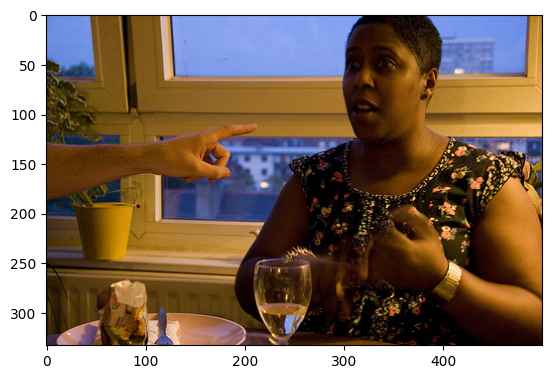

In [117]:
plt.imshow(picture)